In [34]:
# Формируем строку для описания архитектуры модели
def get_model_architecture(model):
    architecture = ""
    for layer in model.layers:
        if isinstance(layer, LSTM):
            architecture += f"LSTM_{layer.units}x{layer.return_sequences}_"
        elif isinstance(layer, Dense):
            architecture += f"Dense{layer.units}_"
    return architecture[:-1]  # Убираем последний символ "_"

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
import joblib
from numpy import sqrt
from keras.losses import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from keras.models import load_model

from free_utils import (
    file_names,
    n_intervals
)

In [79]:

# Путь для сохранения моделей
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


n_intervals = 120
file_id = 7


n_features = 18
data_folder = '../datasets/'
# Загрузка скейлеров
scaler_filename = '../scalers/' + file_names[file_id] + '_scaler.pkl'
with open(scaler_filename, 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)
# Создаем списки для хранения путей и данных
file_paths = [
    'X_test_ltsm_',
    'X_train_ltsm_',
    'y_test_ltsm_',
    'y_train_ltsm_'
]

data = []

# Загружаем данные из файлов .npy
for file_path in file_paths:
    file_name = file_path + file_names[file_id] + '.npy'
    full_path = data_folder + file_name
    data.append(np.load(full_path))

# Теперь переменная 'data' содержит загруженные данные из файлов .npy
X_test_ltsm, X_train_ltsm, y_test_ltsm, y_train_ltsm = data

In [80]:

model = Sequential()

model.add(LSTM(units=77, return_sequences=True, input_shape=(X_train_ltsm.shape[1], X_train_ltsm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=77,return_sequences=False,))
model.add(Dropout(0.2))
model.add(Dense(units=77,activation = 'relu'))
model.add(Dense(units=1,activation = 'linear'))


model.compile(optimizer='adam',loss='mse')


model_architecture = get_model_architecture(model)
print("Model architecture:", model_architecture)

# Определение колбеков
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Формируем путь для сохранения модели
model_filename = os.path.join(models_dir, f'{file_names[file_id]}_{model_architecture}_best_model.h5')
model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True)


Model architecture: LSTM_77xTrue_LSTM_77xFalse_Dense77_Dense1


In [81]:
# Обучение модели с использованием колбеков
history = model.fit(
                    X_train_ltsm, y_train_ltsm,
                    epochs=5, batch_size=32,
                    validation_data=(X_test_ltsm, y_test_ltsm),
                    callbacks=[early_stopping, model_checkpoint],
                    )

Epoch 1/5
64/64 [==============================] - 19s 227ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 2/5
64/64 [==============================] - 13s 208ms/step - loss: 9.4606e-04 - val_loss: 0.0030
Epoch 3/5
64/64 [==============================] - 13s 206ms/step - loss: 5.9740e-04 - val_loss: 0.0034
Epoch 4/5
64/64 [==============================] - 13s 208ms/step - loss: 5.2180e-04 - val_loss: 0.0023
Epoch 5/5
64/64 [==============================] - 15s 234ms/step - loss: 4.0492e-04 - val_loss: 0.0037


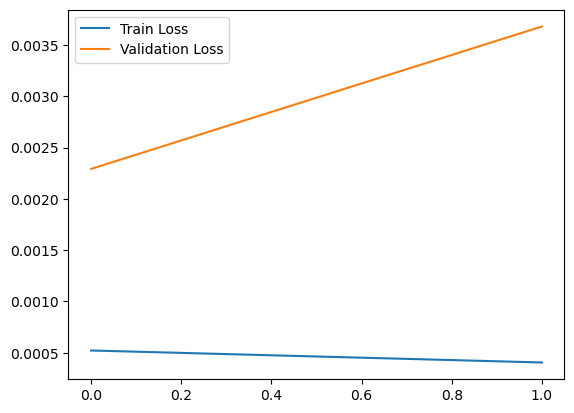

In [82]:
# Визуализация процесса обучения, начиная с 4-й эпохи
plt.plot(history.history['loss'][3:], label='Train Loss')
plt.plot(history.history['val_loss'][3:], label='Validation Loss')
plt.legend()
plt.show()

In [83]:
# # Путь к сохраненной модели
# saved_model_path = 'models/Прошлые данные - LKOH.csv_LSTM_100xTrue_LSTM_100xFalse_Dense256_Dense256_Dense1_best_model.h5'
#     
# # Загружаем модель
# loaded_model = load_model(saved_model_path)
# model = loaded_model
# Теперь у вас есть загруженная модель, готовая к использованию


In [84]:
X_train_ltsm_res = X_train_ltsm.reshape((X_train_ltsm.shape[0], n_intervals*n_features))

# invert scaling for actual
y_train_ltsm_res = y_train_ltsm.reshape((len(y_train_ltsm), 1))
inv_y_train = np.concatenate((y_train_ltsm_res, X_train_ltsm_res[:, (1-n_features):]), axis=1)

inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]
yhat = model.predict(X_test_ltsm)
X_test_ltsm_res = X_test_ltsm.reshape((X_test_ltsm.shape[0], n_intervals*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test_ltsm_res[:, (1-n_features):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y_test_ltsm = y_test_ltsm.reshape((len(y_test_ltsm), 1))
inv_y_test = np.concatenate((y_test_ltsm, X_test_ltsm_res[:, (1-n_features):]), axis=1)

inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]


16/16 [==============================] - 3s 84ms/step


Test RMSE: 87.561


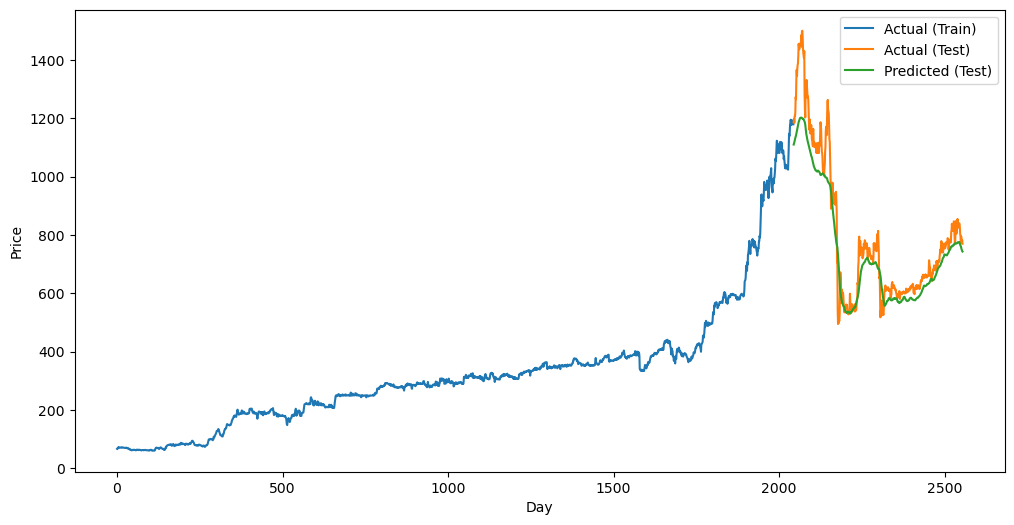

In [85]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat))

# Print RMSE
print("Test RMSE: %.3f" % rmse)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(inv_y_train, label='Actual (Train)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_y_test, label='Actual (Test)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_yhat, label='Predicted (Test)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [209]:
# Прогнозирование следующих 300 дней
forecast_days = 250
# Используем исходные данные из тестового набора для первых 60 дней
forecast = y_test_ltsm[-n_intervals:].tolist()
forecast =[item for sublist in forecast for item in sublist]
# Используем последние 60 дней из тестового набора
last_60_days = X_test_ltsm[-n_intervals:]

for i in range(forecast_days):
    # Используйте модель для прогнозирования следующего дня
    next_day_prediction = model.predict(last_60_days)
    next_day = next_day_prediction
        # Добавьте прогноз в список прогнозов
    forecast.append(next_day[0, 0])

    # Обновите last_60_days, удалив первый день и добавив новый прогноз
    last_60_days = np.roll(last_60_days, shift=-1, axis=0)
    last_60_days[-1] = next_day


4/4 [==============================] - 0s 81ms/step


In [210]:

# Обратное масштабирование прогнозов
forecast = np.array(forecast)
# Повторяем прогнозы для каждого признака
forecast = np.repeat(forecast, n_features).reshape(-1, n_features)
forecast = scaler.inverse_transform(forecast)[:, 0]
forecast = forecast[n_intervals:]

# Результаты прогнозирования
print(f"Прогнозы на следующие {forecast_days} дней:")
forecast

Прогнозы на следующие 250 дней:


array([616.60653121, 620.50325172, 624.79580717, 626.16815535,
       625.49367912, 623.95515252, 623.89451288, 625.48417461,
       625.36818517, 625.61844195, 626.58656887, 628.31707799,
       630.95550446, 631.25822958, 630.99356551, 631.19092388,
       632.22743167, 634.37609627, 634.6171926 , 635.39243385,
       637.98269266, 641.5374228 , 646.03352961, 647.94578563,
       648.30123714, 648.34239468, 648.95820959, 646.30034403,
       644.04128088, 643.58235491, 645.49387982, 645.46523726,
       645.82374226, 646.84717597, 649.34793755, 653.67773691,
       655.87736462, 657.84501344, 660.03689991, 663.17012004,
       667.55492515, 670.33845669, 673.53244548, 677.43015515,
       681.53034101, 685.42676048, 686.89621809, 687.67145935,
       688.57081833, 690.02935221, 692.57144336, 693.44078357,
       694.94727008, 697.73230685, 702.0651167 , 703.69245242,
       705.70379619, 708.85232675, 713.03499972, 718.08211013,
       720.49509475, 721.88210827, 723.65278577, 726.92

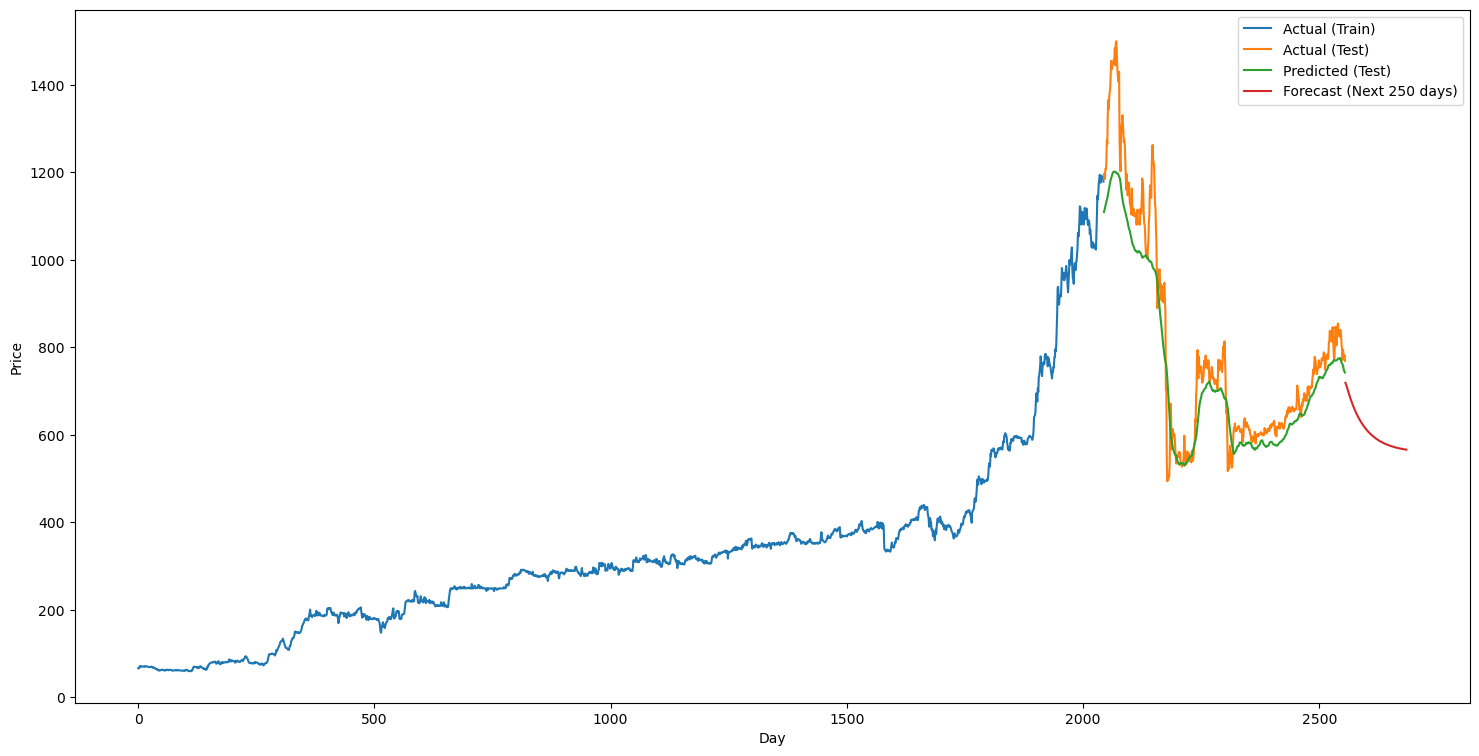

In [214]:
# Visualize the resultsforecast = forecast[n_intervals:]

forecast_reversed = forecast[n_intervals:]

plt.figure(figsize=(18, 9))
plt.plot(inv_y_train, label='Actual (Train)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_y_test, label='Actual (Test)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_yhat, label='Predicted (Test)')
plt.plot(
    range(len(inv_y_train) + len(inv_y_test), len(inv_y_train) + len(inv_y_test) + len(forecast_reversed)),forecast_reversed,label=f'Forecast (Next {forecast_days} days)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# # Изменим форму массива на ожидаемую
# # Изменим форму массива на ожидаемую
# predictions_inverted = predictions_inverted.reshape(-1, num_days)
# 
# predictions_inverted = predictions_inverted.transpose()
# predictions_LTSM_test = predictions_inverted
# 
# # Inverse transform the predictions
# y_test_LTSM = scaler.inverse_transform(y_test_LTSM.reshape(-1, 1))
# # Calculate metrics
# mse = mean_squared_error(y_test_LTSM, predictions_LTSM_test)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_LTSM, predictions_LTSM_test)
# 
# print('RMSE (Root Mean Squared Error):', rmse)
# print('R2 (Coefficient of Determination):', r2)
# def calculate_mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# 
# # Вычисляем MAPE
# mape = calculate_mape(y_test_LTSM, predictions_LTSM_test)
# print('MAPE (Mean Absolute Percentage Error):', mape)
